### ***Probelm Statement***
Automated Essay Evaluation Pipeline using LangGraph
Overview

The objective of this mini project is to design and implement an automated essay evaluation pipeline using LangGraph. The system will simulate a multi-step workflow where an LLM generates an essay and then passes it through several evaluation nodes, each responsible for a specific dimension of academic writing quality.

In [20]:
from langchain_huggingface import ChatHuggingFace,HuggingFaceEndpoint
from dotenv import load_dotenv
from langgraph.graph import StateGraph, START, END
from typing import TypedDict
import os
from langchain_core.output_parsers import JsonOutputParser
from pydantic import BaseModel, Field
from typing import Annotated

In [8]:
load_dotenv()
# Load HUGGINGFACE_API_KEY from environment 
api_key = os.environ.get("HUGGINGFACEHUB_API_TOKEN")
if not api_key:
    raise RuntimeError('HUGGINGFACEHUB_API_TOKEN not set. Add it to .env or set the environment variable.')

In [14]:
#  Initialize Endpoint with the correct task
llm = HuggingFaceEndpoint(
    repo_id="openai/gpt-oss-20b",
    task="text-generation",  
    
)

# 3. Wrap in Chat Interface
model = ChatHuggingFace(llm=llm)

In [29]:


# Define your evaluation schema
class Evalution(BaseModel):
    score: int = Field(description="Score from 1-10",ge=1,le=10)
    feedback: str = Field(description="Detailed Feedback for the essay")
    # ...add other fields as needed

# Create parser
parser = JsonOutputParser(pydantic_object=Evalution)

# Get format instructions
format_instructions = parser.get_format_instructions()

# Build prompt with JSON format instructions
from langchain_core.prompts import PromptTemplate

prompt = PromptTemplate(
    template="Evaluate the following:\n{text}\n\n{format_instructions}",
    input_variables=["text"],
    partial_variables={"format_instructions": format_instructions}
)

# Chain: prompt | model | parser
chain = prompt | model | parser
essay_text = """
Artificial Intelligence (AI) is reshaping the global financial landscape, and Bangladesh is no exception. With increasing digital adoption, expanding mobile financial services, and growing customer expectations, Bangladeshi banks are now actively exploring AI-driven solutions to enhance operational efficiency, reduce risk, and deliver superior customer experiences. Although still at an early stage compared to more advanced economies, the integration of AI in Bangladesh’s banking sector is accelerating rapidly, supported by regulatory encouragement, fintech collaboration, and the rise of digital transformation agendas within financial institutions.

One of the most significant applications of AI in Bangladeshi banking is customer service automation. Banks are increasingly deploying AI-powered chatbots to provide round-the-clock customer support, deliver personalized responses, and reduce branch-level service pressure. These chatbots help customers check balances, inquire about loan eligibility, or resolve transactional issues without waiting in long queues or calling help desks. As customer interactions shift more toward digital channels such as mobile banking apps and websites, AI systems enable banks to maintain high-quality service at scale.

AI has also emerged as a critical tool in fraud detection and risk management. With millions of daily digital transactions occurring across ATM, internet banking, and mobile financial services (MFS), traditional rule-based monitoring is insufficient. Modern AI-driven fraud detection models analyze patterns, identify anomalies, and flag suspicious activities in real time. Bangladeshi banks are gradually adopting machine learning to strengthen anti-money laundering (AML) monitoring, transaction screening, and credit scoring. This enhances both speed and accuracy in decision-making, reducing non-performing loans and financial losses.

In addition, AI is transforming operational efficiency through automation. Robotic Process Automation (RPA) and intelligent document processing are being implemented to handle repetitive, error-prone tasks such as KYC verification, loan application processing, and reconciliation. For example, eKYC solutions powered by AI-based face matching and OCR have significantly reduced onboarding time while increasing compliance reliability. These solutions help banks offer faster account opening processes and support financial inclusion objectives across rural areas.

Another emerging application area is personalized financial services. AI-driven analytics enable banks to segment customers, predict financial behaviors, and recommend tailored products. This allows them to improve marketing effectiveness, cross-sell more intelligently, and enhance customer satisfaction. As Bangladeshi consumers become more digitally savvy, demand for personalized banking solutions will continue to grow.

Despite these advancements, several challenges remain. Limited AI expertise, high implementation costs, cybersecurity concerns, and regulatory uncertainties sometimes slow adoption. Many banks still rely heavily on legacy systems, making integration complex. However, as the central bank continues to promote digital innovation and fintech partnerships expand, these barriers are gradually diminishing.

In conclusion, AI is becoming an essential driver of modernization in the Bangladeshi banking industry. It strengthens fraud prevention, increases operational efficiency, enhances customer service, and enables data-driven decision-making. As the sector moves toward fully digital banking models, the successful and responsible deployment of AI will play a pivotal role in shaping a more secure, efficient, and customer-centric financial ecosystem in Bangladesh.

"""
# Invoke
result = chain.invoke({"text": essay_text})
result['score'] # Returns Evalution object with score and feedback

8

In [41]:
import operator
class EssayEvaluationState(TypedDict):
    essay: str
    language_feedback: str
    depth_analysis: str
    clarity_feedback: str
    overall_feedback: str
    individual_scores: Annotated[list[int],operator.add]
    average_score: float

In [42]:
def evaluate_language(state: EssayEvaluationState) ->EssayEvaluationState:
    prompt=f"Evaluate the language quality of the essay and provide a feedback and rating score out of 10 {state['essay']}"
    output=chain.invoke(prompt)
    return {'language_feedback': output['feedback'], 'individual_scores':[output['score']]}


In [43]:
def evaluate_analysis(state: EssayEvaluationState) ->EssayEvaluationState:
    prompt=f"Evaluate the Depth analysis of the essay and provide a depth feedback and rating score out of 10 {state['essay']}"
    output=chain.invoke(prompt)
    return {'depth_analysis': output['feedback'], 'individual_scores': [output['score']]}

In [44]:
def evaluate_clarity(state: EssayEvaluationState) ->EssayEvaluationState:
    prompt=f"Evaluate the Clarity of the essay and provide a clarity feedback and rating score out of 10 {state['essay']}"
    output=chain.invoke(prompt)
    return {'clarity_feedback': output['feedback'], 'individual_scores': [output['score']]}

In [49]:
def final_evaluation(state: EssayEvaluationState) ->EssayEvaluationState:
    prompt=f"Based on the following feedbacks, provide an overall feedback and average score out of 10:\n Language Feedback: {state['language_feedback']}\n Depth Analysis: {state['depth_analysis']}\n Clarity Feedback: {state['clarity_feedback']}"
    output=chain.invoke(prompt)

    # calculate average score
    average_score = sum(state['individual_scores']) / len(state['individual_scores'])
    return {'overall_feedback': output['feedback'], 'average_score': average_score}

In [50]:
# Define the graph

graph = StateGraph(EssayEvaluationState)

graph.add_node("evaluate_language", evaluate_language)
graph.add_node("evaluate_analysis", evaluate_analysis)
graph.add_node("evaluate_clarity", evaluate_clarity)
graph.add_node("final_evaluation", final_evaluation)

graph.add_edge(START, "evaluate_language")
graph.add_edge(START, "evaluate_analysis")
graph.add_edge(START, "evaluate_clarity")
graph.add_edge("evaluate_language", "final_evaluation")
graph.add_edge("evaluate_analysis", "final_evaluation")
graph.add_edge("evaluate_clarity", "final_evaluation")
graph.add_edge("final_evaluation", END)
workflow = graph.compile()


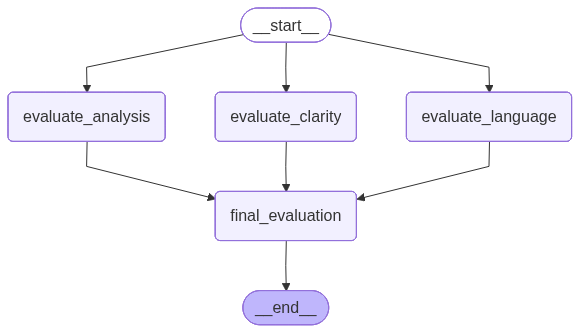

In [51]:
workflow

In [52]:
initial_state={
    'essay': essay_text
}
workflow.invoke(initial_state)

{'essay': '\nArtificial Intelligence (AI) is reshaping the global financial landscape, and Bangladesh is no exception. With increasing digital adoption, expanding mobile financial services, and growing customer expectations, Bangladeshi banks are now actively exploring AI-driven solutions to enhance operational efficiency, reduce risk, and deliver superior customer experiences. Although still at an early stage compared to more advanced economies, the integration of AI in Bangladesh’s banking sector is accelerating rapidly, supported by regulatory encouragement, fintech collaboration, and the rise of digital transformation agendas within financial institutions.\n\nOne of the most significant applications of AI in Bangladeshi banking is customer service automation. Banks are increasingly deploying AI-powered chatbots to provide round-the-clock customer support, deliver personalized responses, and reduce branch-level service pressure. These chatbots help customers check balances, inquire 